# fig — ood (final)

**Motivation**: host = ```mach```, device = ```cuda:0``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [7]:
def _prep_fig():
    # make plots
    vld = make_dataset(ds_tgt)[1]
    x, g = vld.tensors

    src = tonp(x)[inds[ds_tgt]]
    recon = results['recon'][:, -1][inds[ds_tgt]]
    recon = recon.reshape(tr.model.cfg.shape)
    return src, recon


def _save_fig():
    fig_base_name = f"{analysis_name}_{model_name}"

    for row in [True, False]:
        row_col_str = 'row' if row else 'col'

        fig, ax = plot_row_or_col(src, row=row, display=False)
        fig_name = f"{fig_base_name}_{row_col_str}-input.png"
        fig_name = pjoin(fig_dir, fig_name)
        fig.savefig(fig_name, **kws_fig)
    
        fig, ax = plot_row_or_col(recon, row=row, display=False)
        fig_name = f"{fig_base_name}_{row_col_str}-recon.png"
        fig_name = pjoin(fig_dir, fig_name)
        fig.savefig(fig_name, **kws_fig)


def _extract_model_type(name):
    mapping = {
        'SAVAE': 'sa-VAE',
        'MARINO-single': 'ia-VAE (single-level)',
        'MARINO-hier': 'ia-VAE (hierarchical)'
    }
    
    if '~' not in name:
        name = '~'.join(f.split('_')[:-1])
    model = name.split('~')[0]
    if 'hierarchical' in name:
        model = f"{model}-hier"
    elif 'single' in name:
        model = f"{model}-single"
    elif model == 'SAVAE':
        pass
    else:
        raise ValueError(name)

    model = mapping[model]
    return model


def _extract_src_tgt(name):
    def _final_processing(s):
        s = str(s)
        if s.lower() == 'omniglot':
            s = s.capitalize()
        else:
            s = s.upper()
        return s

    if '~' not in name:
        name = '~'.join(f.split('_')[:-1])
    from_to_part = [
        part for part in name.split('~')
        if 'from-' in part
    ][0]
    ds_src = from_to_part.split('-')[1]
    ds_tgt = from_to_part.split('-')[3]
    ds_src, ds_tgt = map(
        _final_processing,
        [ds_src, ds_tgt],
    )
    return ds_src, ds_tgt




In [8]:
inds_when_tgt_omni

array([7722, 7733, 7723, ..., 9979, 9973, 9969])

In [3]:
from analysis.chosen import *
from figures.analysis import *
from analysis.ood import ood_analysis, LogisticRegression

device_idx = 0
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:0  ———  host: mach

In [4]:
fig_base_dir = pjoin(fig_base_dir, 'iclr_oct02', 'ood')
os.makedirs(fig_base_dir, exist_ok=True)
print(os.listdir(fig_base_dir))

kws_fig = {
    'transparent': True,
    'bbox_inches': 'tight',
    'dpi': 300,
}

[
    'ood_src-EMNIST_tgt-EMNIST',
    'ood_src-EMNIST_tgt-MNIST',
    'ood_src-Omniglot_tgt-Omniglot',
    'ood_src-MNIST_tgt-Omniglot',
    'ood_src-MNIST_tgt-MNIST',
    'ood_src-Omniglot_tgt-EMNIST',
    'ood_src-EMNIST_tgt-Omniglot',
    'ood_src-Omniglot_tgt-MNIST',
    'ood_src-MNIST_tgt-EMNIST'
]

## VAE: amort and iterative

In [5]:
models_to_load = selected_models_28x28(device)
models_to_load = {
    m: d for m, d in
    models_to_load.items()
    if 'mlp' in m  # no conv
}
models_to_load = dict(sorted(
    models_to_load.items(),
    key=lambda t: alphanum_sort_key(t[0]),
))
print(list(models_to_load))

[
    'EMNIST_<jacob|mlp>_(64,24.0)',
    'EMNIST_<mlp|mlp>_(64,24.0)',
    'MNIST_<jacob|mlp>_(64,24.0)',
    'MNIST_<mlp|mlp>_(1,1.0)',
    'MNIST_<mlp|mlp>_(64,24.0)',
    'Omniglot_<jacob|mlp>_(64,24.0)',
    'Omniglot_<mlp|mlp>_(64,24.0)'
]

In [6]:
trainers = {}
for model_name, kws_load in models_to_load.items():
    trainers[model_name] = load_model(**kws_load)[0]

In [7]:
datasets = sorted(set(
    m.split('_')[0] for
    m in trainers
))
print(datasets)

['EMNIST', 'MNIST', 'Omniglot']

### init inds

In [8]:
inds = get_dataset_inds()
print(inds)

assert set(inds) == set(datasets)

{
    'MNIST': array([ 0,  1,  2,  3,  4,  7,  8, 11, 18, 61]),
    'EMNIST': [1, 2603, 12293, 15308, 6946, 17043, 3510, 4638, 15626, 18359],
    'Omniglot': array([12710,  5616,  2649,   370,  8713,  9519,  9638,  6146,  9675,
        8900])
}

### init df

In [9]:
df = collections.defaultdict(list)

### loop: our models

______________________________________________________________________________________________________________

model: EMNIST_<jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    4.17
accuracy:       0.760

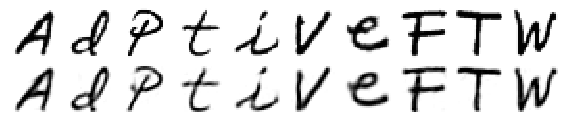

______________________________________________________________________________________________________________

model: EMNIST_<jacob|mlp>_(64,24.0) ——— target: MNIST
mse:    5.73
accuracy:       0.931

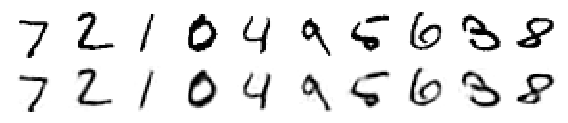

______________________________________________________________________________________________________________

model: EMNIST_<jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    18.55
accuracy:       nan

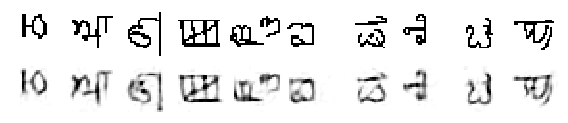

______________________________________________________________________________________________________________

model: EMNIST_<mlp|mlp>_(64,24.0) ——— target: EMNIST
mse:    5.82
accuracy:       0.778

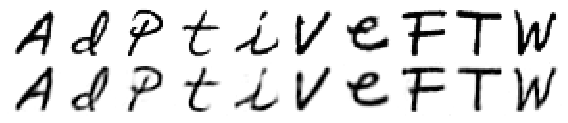

______________________________________________________________________________________________________________

model: EMNIST_<mlp|mlp>_(64,24.0) ——— target: MNIST
mse:    11.79
accuracy:       0.936

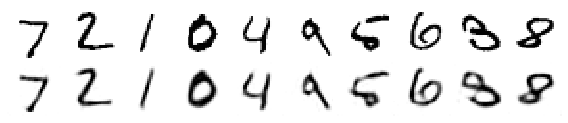

______________________________________________________________________________________________________________

model: EMNIST_<mlp|mlp>_(64,24.0) ——— target: Omniglot
mse:    40.28
accuracy:       nan

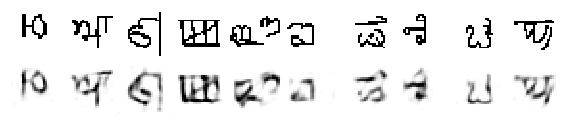

______________________________________________________________________________________________________________

model: MNIST_<jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    13.10
accuracy:       0.765

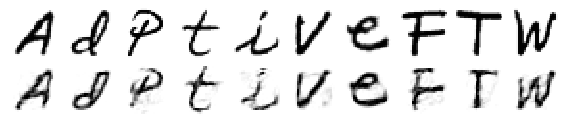

______________________________________________________________________________________________________________

model: MNIST_<jacob|mlp>_(64,24.0) ——— target: MNIST
mse:    3.97
accuracy:       0.959

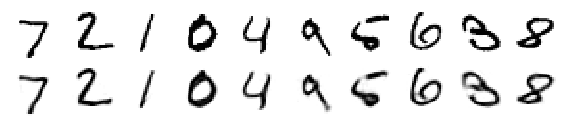

______________________________________________________________________________________________________________

model: MNIST_<jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    18.90
accuracy:       nan

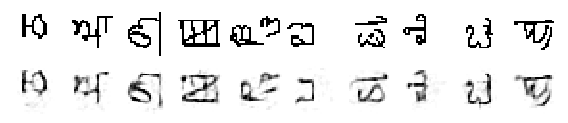

______________________________________________________________________________________________________________

model: MNIST_<mlp|mlp>_(64,24.0) ——— target: EMNIST
mse:    143.23
accuracy:       0.403

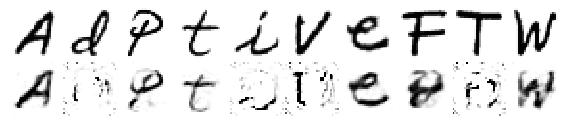

______________________________________________________________________________________________________________

model: MNIST_<mlp|mlp>_(64,24.0) ——— target: MNIST
mse:    5.53
accuracy:       0.950

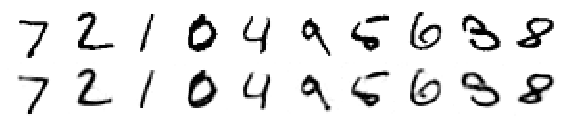

______________________________________________________________________________________________________________

model: MNIST_<mlp|mlp>_(64,24.0) ——— target: Omniglot
mse:    73.97
accuracy:       nan

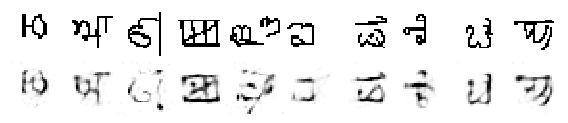

______________________________________________________________________________________________________________

model: Omniglot_<jacob|mlp>_(64,24.0) ——— target: EMNIST
mse:    12.47
accuracy:       0.727

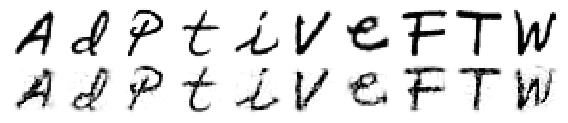

______________________________________________________________________________________________________________

model: Omniglot_<jacob|mlp>_(64,24.0) ——— target: MNIST
mse:    8.90
accuracy:       0.925

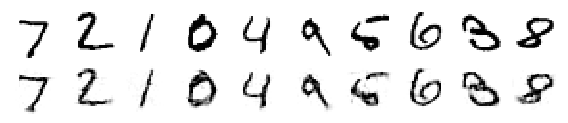

______________________________________________________________________________________________________________

model: Omniglot_<jacob|mlp>_(64,24.0) ——— target: Omniglot
mse:    9.75
accuracy:       nan

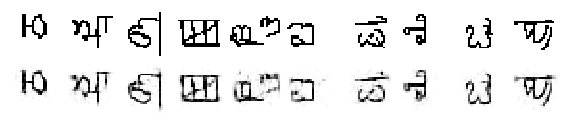

______________________________________________________________________________________________________________

model: Omniglot_<mlp|mlp>_(64,24.0) ——— target: EMNIST
mse:    25.54
accuracy:       0.692

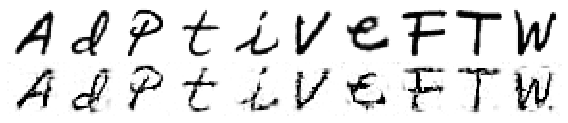

______________________________________________________________________________________________________________

model: Omniglot_<mlp|mlp>_(64,24.0) ——— target: MNIST
mse:    15.15
accuracy:       0.905

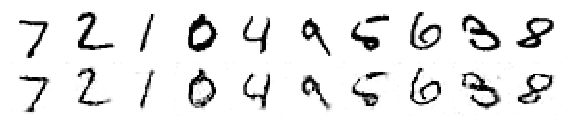

______________________________________________________________________________________________________________

model: Omniglot_<mlp|mlp>_(64,24.0) ——— target: Omniglot
mse:    12.87
accuracy:       nan

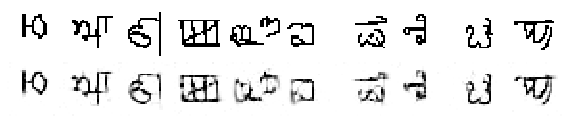

CPU times: user 25min 58s, sys: 6min 38s, total: 32min 36s
Wall time: 22min 13s


In [10]:
%%time


for model_name, tr in trainers.items():
    if tr.model.cfg.enc_type == 'jacob':
        is_ipvae = True
    else:
        is_ipvae = False

    tr.cfg.batch_size = 1500
    t_recon = 1000 if is_ipvae else -1

    ds_src = tr.model.cfg.dataset
    assert ds_src == model_name.split('_')[0]

    for ds_tgt in datasets:
        analysis_name = f"ood_src-{ds_src}_tgt-{ds_tgt}"
        fig_dir = pjoin(fig_base_dir, analysis_name)
        os.makedirs(fig_dir, exist_ok=True)

        accuracy, results = ood_analysis(
            tr=tr,
            dataset=ds_tgt,
            n_data_batches=None,
            t_clf=-1,
            t_recon=t_recon,
            verbose=False,
        )

        print('_' * 110)
        msg = '\n'.join([
            f"model: {model_name} ——— target: {ds_tgt}",
            f"mse:\t{results['mse'][-1]:0.2f}",
            f"accuracy:\t{accuracy:0.3f}",
        ])
        print(msg)

        # save results
        df['analysis_name'].append(analysis_name)
        df['ds_src'].append(ds_src)
        df['ds_tgt'].append(ds_tgt)
        df['model'].append('iP-VAE' if is_ipvae else 'aiP-VAE')
        df['enc_type'].append(tr.model.cfg.enc_type)
        df['dec_type'].append(tr.model.cfg.dec_type)
        df['n_iters_train'].append(tr.model.cfg.seq_len)
        df['n_iters_test'].append(results['props']['t_recon'])
        df['mse'].append(results['mse'][-1])
        df['accuracy'].append(accuracy)

        src, recon = _prep_fig()
        _save_fig()

        # show fig (for sanity check only)
        x2p = np.concatenate([src, recon])
        _ = plot_weights(
            x2p, nrows=2, cmap='Greys',
            method='none', dpi=70,
            vmin=0.05, vmax=1.0,
        )
        print('\n\n')

## Marino & Kim

In [11]:
dekel_dir = '/home/hadi/Dropbox/git/jb-vae/tmp/dekel_data/rot_full'

dekel_files = sorted(
    os.listdir(dekel_dir),
    key=alphanum_sort_key,
)
across_files = [
    f for f in dekel_files
    if '_from' in f
]
within_files = [
    f for f in dekel_files
    if 'rotate' not in f
    and 'from' not in f
    and '_vh_' not in f
]
selected_dekel_files = sorted(
    across_files + within_files,
    key=alphanum_sort_key,
)
print(selected_dekel_files)

[
    'MARINO_emnist_hierarchical_iterative_EMNIST_H_10_full.npz',
    'MARINO_emnist_single_level_iterative_EMNIST_SL_10_full.npz',
    'MARINO_hierarchical_from-emnist-to-mnist_EMNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-emnist-to-omniglot_EMNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-mnist-to-emnist_MNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-mnist-to-omniglot_MNIST_H_iters10_full.npz',
    'MARINO_hierarchical_from-omniglot-to-emnist_OMNIGLOT_HADI_H_iters10_full.npz',
    'MARINO_hierarchical_from-omniglot-to-mnist_OMNIGLOT_HADI_H_iters10_full.npz',
    'MARINO_mnist_hierarchical_iterative_MNIST_H_10_full.npz',
    'MARINO_mnist_single_level_iterative_MNIST_SL_10_full.npz',
    'MARINO_omniglot-hadi_hierarchical_iterative_OMNIGLOT_HADI_H_10_full.npz',
    'MARINO_omniglot-hadi_single_level_iterative_OMNIGLOT_HADI_SL_10_full.npz',
    'MARINO_single_level_from-emnist-to-mnist_EMNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-emnist-to-omniglot_EMNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-mnist-to-emnist_MNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-mnist-to-omniglot_MNIST_SL_iters10_full.npz',
    'MARINO_single_level_from-omniglot-to-emnist_OMNIGLOT_HADI_SL_iters10_full.npz',
    'MARINO_single_level_from-omniglot-to-mnist_OMNIGLOT_HADI_SL_iters10_full.npz',
    'SAVAE_emnist_iter20_full.npz',
    'SAVAE_from-emnist-to-mnist_iter20_full.npz',
    'SAVAE_from-emnist-to-omniglot_iter20_full.npz',
    'SAVAE_from-mnist-to-emnist_iter20_full.npz',
    'SAVAE_from-mnist-to-omniglot_iter20_full.npz',
    'SAVAE_from-omniglot-to-emnist_iter20_full.npz',
    'SAVAE_from-omniglot-to-mnist_iter20_full.npz',
    'SAVAE_mnist_iter20_full.npz',
    'SAVAE_omniglot_iter20_full.npz'
]

### loop: across-dataset

______________________________________________________________________________________________________________

model: MARINO~hierarchical~from-emnist-to-mnist~EMNIST~H~iters10 ——— analysis: ood_src-EMNIST_tgt-MNIST
mse:    12.20
accuracy:       0.852

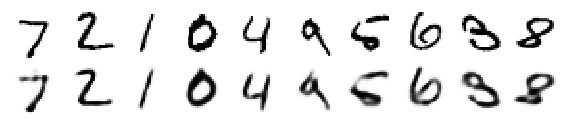

______________________________________________________________________________________________________________

model: MARINO~hierarchical~from-emnist-to-omniglot~EMNIST~H~iters10 ——— analysis: ood_src-EMNIST_tgt-Omniglot
mse:    31.37
accuracy:       nan

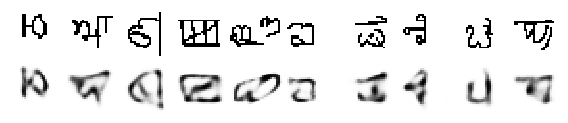

______________________________________________________________________________________________________________

model: MARINO~hierarchical~from-mnist-to-emnist~MNIST~H~iters10 ——— analysis: ood_src-MNIST_tgt-EMNIST
mse:    30.67
accuracy:       0.491

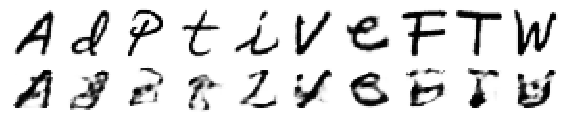

______________________________________________________________________________________________________________

model: MARINO~hierarchical~from-mnist-to-omniglot~MNIST~H~iters10 ——— analysis: ood_src-MNIST_tgt-Omniglot
mse:    42.87
accuracy:       nan

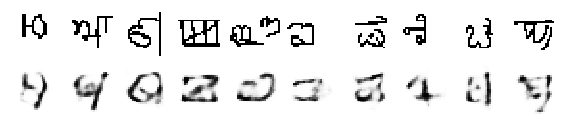

______________________________________________________________________________________________________________

model: MARINO~hierarchical~from-omniglot-to-emnist~OMNIGLOT~HADI~H~iters10 ——— analysis: 
ood_src-Omniglot_tgt-EMNIST
mse:    64.66
accuracy:       0.401

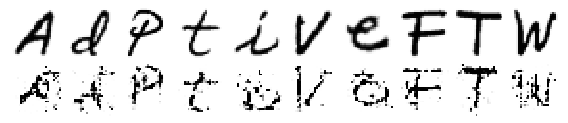

______________________________________________________________________________________________________________

model: MARINO~hierarchical~from-omniglot-to-mnist~OMNIGLOT~HADI~H~iters10 ——— analysis: ood_src-Omniglot_tgt-MNIST
mse:    44.81
accuracy:       0.725

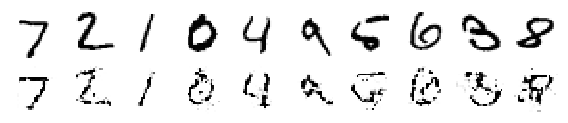

______________________________________________________________________________________________________________

model: MARINO~single~level~from-emnist-to-mnist~EMNIST~SL~iters10 ——— analysis: ood_src-EMNIST_tgt-MNIST
mse:    12.01
accuracy:       0.928

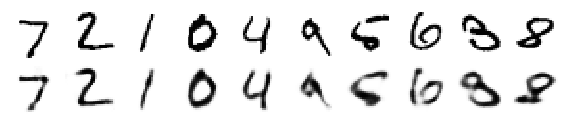

______________________________________________________________________________________________________________

model: MARINO~single~level~from-emnist-to-omniglot~EMNIST~SL~iters10 ——— analysis: ood_src-EMNIST_tgt-Omniglot
mse:    30.35
accuracy:       nan

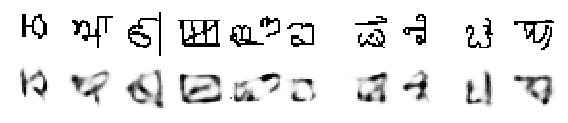

______________________________________________________________________________________________________________

model: MARINO~single~level~from-mnist-to-emnist~MNIST~SL~iters10 ——— analysis: ood_src-MNIST_tgt-EMNIST
mse:    27.17
accuracy:       0.050

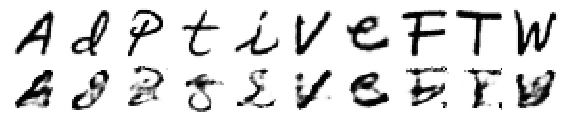

______________________________________________________________________________________________________________

model: MARINO~single~level~from-mnist-to-omniglot~MNIST~SL~iters10 ——— analysis: ood_src-MNIST_tgt-Omniglot
mse:    36.84
accuracy:       nan

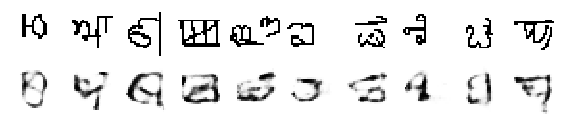

______________________________________________________________________________________________________________

model: MARINO~single~level~from-omniglot-to-emnist~OMNIGLOT~HADI~SL~iters10 ——— analysis: 
ood_src-Omniglot_tgt-EMNIST
mse:    39.45
accuracy:       0.605

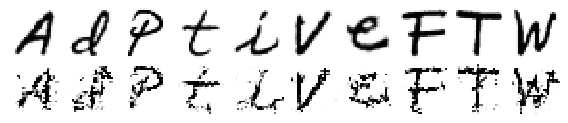

______________________________________________________________________________________________________________

model: MARINO~single~level~from-omniglot-to-mnist~OMNIGLOT~HADI~SL~iters10 ——— analysis: ood_src-Omniglot_tgt-MNIST
mse:    25.96
accuracy:       0.871

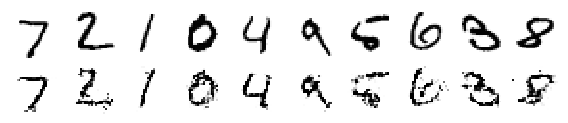

______________________________________________________________________________________________________________

model: SAVAE~from-emnist-to-mnist~iter20 ——— analysis: ood_src-EMNIST_tgt-MNIST
mse:    11.57
accuracy:       0.888

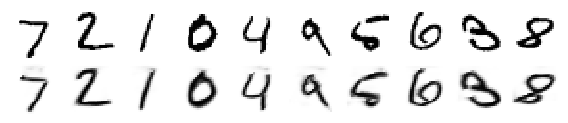

______________________________________________________________________________________________________________

model: SAVAE~from-emnist-to-omniglot~iter20 ——— analysis: ood_src-EMNIST_tgt-Omniglot
mse:    28.73
accuracy:       nan

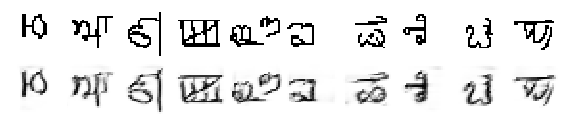

______________________________________________________________________________________________________________

model: SAVAE~from-mnist-to-emnist~iter20 ——— analysis: ood_src-MNIST_tgt-EMNIST
mse:    16.30
accuracy:       0.597

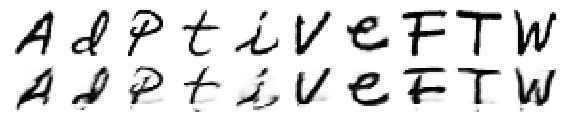

______________________________________________________________________________________________________________

model: SAVAE~from-mnist-to-omniglot~iter20 ——— analysis: ood_src-MNIST_tgt-Omniglot
mse:    30.70
accuracy:       nan

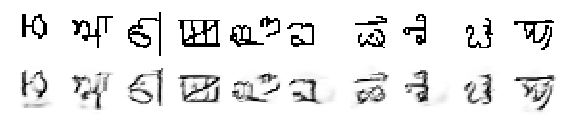

______________________________________________________________________________________________________________

model: SAVAE~from-omniglot-to-emnist~iter20 ——— analysis: ood_src-Omniglot_tgt-EMNIST
mse:    12.96
accuracy:       0.678

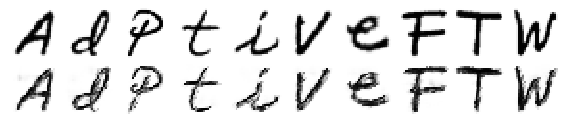

______________________________________________________________________________________________________________

model: SAVAE~from-omniglot-to-mnist~iter20 ——— analysis: ood_src-Omniglot_tgt-MNIST
mse:    13.59
accuracy:       0.909

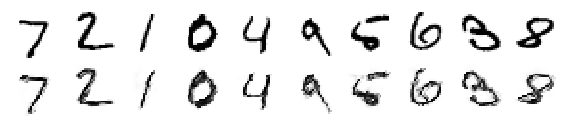

CPU times: user 5min 33s, sys: 26.8 s, total: 6min
Wall time: 11.7 s


In [12]:
%%time


for f in across_files:
    model_name = '~'.join(f.split('_')[:-1])
    load = dict(np.load(
        pjoin(dekel_dir, f),
        allow_pickle=True,
    ))

    ds_src, ds_tgt = _extract_src_tgt(model_name)
    analysis_name = f"ood_src-{ds_src}_tgt-{ds_tgt}"
    n_iters = int_from_str(model_name.split('~')[-1])

    component = f"from-{ds_src}-to-{ds_tgt}".lower()
    assert component in model_name.lower()

    # prep datasets
    trn, vld, _ = make_dataset(ds_tgt)
    src, g_vld = vld.tensors
    src = tonp(src)
    g_trn, g_vld = map(
        lambda g: tonp(g).astype(int),
        [trn.tensors[1], g_vld],
    )

    # prep recon
    recon = load['recons_val'].squeeze()
    recon = recon[:, np.newaxis]
    assert recon.shape == src.shape
    if np.nanmax(recon) > 1:
        recon /= 255

    if ds_tgt == 'Omniglot':
        recon = recon[inds_when_tgt_omni]

    # compute mse
    mse = (src - recon) ** 2
    mse = mse.sum(axis=(1, 2, 3)).mean(0)

    # clf accuracy
    if ds_tgt == 'Omniglot':
        accuracy = np.nan
    else:
        z_vld = load['posteriors_val'][:, 0, 0]
        z_trn = load['posteriors_trn'][:, 0, 0]
        clf = LogisticRegression().fit(z_trn, g_trn)
        accuracy = (clf.predict(z_vld) == g_vld).mean()

    src = src[inds[ds_tgt]]
    recon = recon[inds[ds_tgt]]
    _save_fig()

    # save results
    df['analysis_name'].append(analysis_name)
    df['ds_src'].append(ds_src)
    df['ds_tgt'].append(ds_tgt)
    df['model'].append(_extract_model_type(model_name))
    df['enc_type'].append('-')
    df['dec_type'].append('-')
    df['n_iters_train'].append(n_iters)
    df['n_iters_test'].append(n_iters)
    df['mse'].append(mse)
    df['accuracy'].append(accuracy)

    print('_' * 110)
    msg = '\n'.join([
        f"model: {model_name} ——— analysis: {analysis_name}",
        f"mse:\t{mse:0.2f}",
        f"accuracy:\t{accuracy:0.3f}",
    ])
    print(msg)

    # show fig (for sanity check only)
    x2p = np.concatenate([src, recon])
    _ = plot_weights(
        x2p, nrows=2, cmap='Greys',
        vmin=0.001, vmax=1, dpi=70,
    )
    print('\n\n')

### loop: within-dataset

______________________________________________________________________________________________________________

model: MARINO~emnist~hierarchical~iterative~EMNIST~H~10 ——— analysis: ood_src-EMNIST_tgt-EMNIST
mse:    8.62
accuracy:       0.670

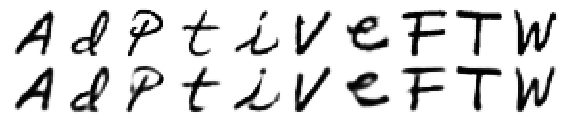

______________________________________________________________________________________________________________

model: MARINO~emnist~single~level~iterative~EMNIST~SL~10 ——— analysis: ood_src-EMNIST_tgt-EMNIST
mse:    8.84
accuracy:       0.683

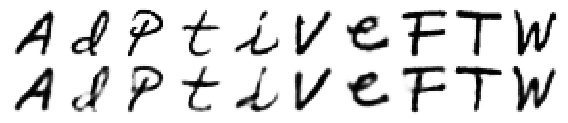

______________________________________________________________________________________________________________

model: MARINO~mnist~hierarchical~iterative~MNIST~H~10 ——— analysis: ood_src-MNIST_tgt-MNIST
mse:    7.45
accuracy:       0.909

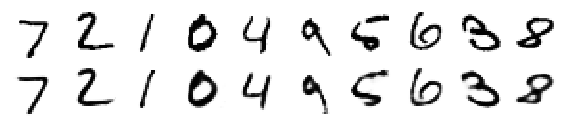

______________________________________________________________________________________________________________

model: MARINO~mnist~single~level~iterative~MNIST~SL~10 ——— analysis: ood_src-MNIST_tgt-MNIST
mse:    7.39
accuracy:       0.931

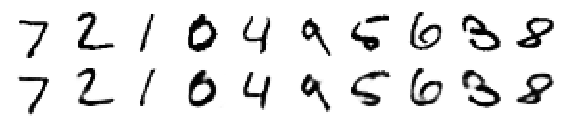

______________________________________________________________________________________________________________

model: MARINO~omniglot-hadi~hierarchical~iterative~OMNIGLOT~HADI~H~10 ——— analysis: ood_src-Omniglot_tgt-Omniglot
mse:    35.36
accuracy:       nan

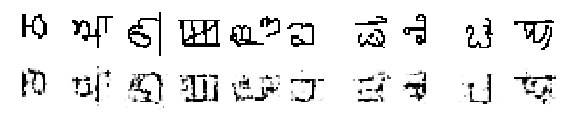

______________________________________________________________________________________________________________

model: MARINO~omniglot-hadi~single~level~iterative~OMNIGLOT~HADI~SL~10 ——— analysis: ood_src-Omniglot_tgt-Omniglot
mse:    21.26
accuracy:       nan

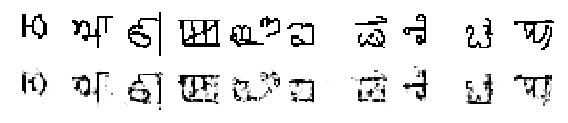

______________________________________________________________________________________________________________

model: SAVAE~emnist~iter20 ——— analysis: ood_src-EMNIST_tgt-EMNIST
mse:    6.02
accuracy:       0.606

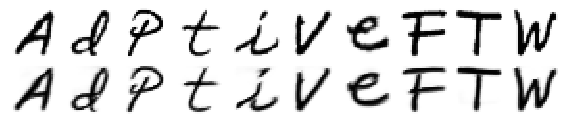

______________________________________________________________________________________________________________

model: SAVAE~mnist~iter20 ——— analysis: ood_src-MNIST_tgt-MNIST
mse:    6.54
accuracy:       0.864

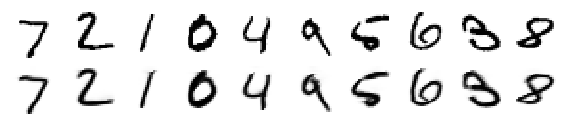

______________________________________________________________________________________________________________

model: SAVAE~omniglot~iter20 ——— analysis: ood_src-Omniglot_tgt-Omniglot
mse:    18.26
accuracy:       nan

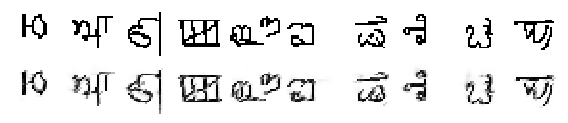

CPU times: user 2min 45s, sys: 14 s, total: 2min 59s
Wall time: 5.66 s


In [14]:
%%time


for f in within_files:
    model_name = '~'.join(f.split('_')[:-1])
    load = dict(np.load(
        pjoin(dekel_dir, f),
        allow_pickle=True,
    ))

    model, dataset = _extract_from_within(f)
    analysis_name = f"ood_src-{dataset}_tgt-{dataset}"
    n_iters = int_from_str(model_name.split('~')[-1])

    # prep datasets
    trn, vld, _ = make_dataset(dataset)
    src, g_vld = vld.tensors
    src = tonp(src)
    g_trn, g_vld = map(
        lambda g: tonp(g).astype(int),
        [trn.tensors[1], g_vld],
    )

    # prep recon
    recon = load['recons_val'].squeeze()
    recon = recon[:, np.newaxis]
    assert recon.shape == src.shape
    if np.nanmax(recon) > 1:
        recon /= 255
        
    if dataset == 'Omniglot':
        recon = recon[inds_when_tgt_omni]
    
    # compute mse
    mse = (src - recon) ** 2
    mse = mse.sum(axis=(1, 2, 3)).mean(0)

    # clf accuracy
    if dataset == 'Omniglot':
        accuracy = np.nan
    else:
        z_vld = load['posteriors_val'][:, 0, 0]
        z_trn = load['posteriors_trn'][:, 0, 0]
        clf = LogisticRegression().fit(z_trn, g_trn)
        accuracy = (clf.predict(z_vld) == g_vld).mean()

    src = src[inds[dataset]]
    recon = recon[inds[dataset]]
    _save_fig()

    # save results
    df['analysis_name'].append(analysis_name)
    df['ds_src'].append(dataset)
    df['ds_tgt'].append(dataset)
    df['model'].append(_extract_model_type(model_name))
    df['enc_type'].append('-')
    df['dec_type'].append('-')
    df['n_iters_train'].append(n_iters)
    df['n_iters_test'].append(n_iters)
    df['mse'].append(mse)
    df['accuracy'].append(accuracy)

    print('_' * 110)
    msg = '\n'.join([
        f"model: {model_name} ——— analysis: {analysis_name}",
        f"mse:\t{mse:0.2f}",
        f"accuracy:\t{accuracy:0.3f}",
    ])
    print(msg)

    # show fig (for sanity check only)
    x2p = np.concatenate([src, recon])
    _ = plot_weights(
        x2p, nrows=2, cmap='Greys',
        vmin=0.001, vmax=1, dpi=70,
    )
    print('\n\n')

In [15]:
df = pd.DataFrame(df)

save_obj(
    obj=df,
    file_name='df_ood',
    save_dir=tmp_dir,
    mode='df',
)

[PROGRESS] 'df_ood.df' saved at
/home/hadi/Dropbox/git/jb-vae/tmp

In [16]:
order = [
    'ood_src-MNIST_tgt-MNIST',
    'ood_src-MNIST_tgt-EMNIST',
    'ood_src-MNIST_tgt-Omniglot',
    'ood_src-EMNIST_tgt-EMNIST',
    'ood_src-EMNIST_tgt-MNIST',
    'ood_src-MNIST_tgt-Omniglot',
    'ood_src-Omniglot_tgt-Omniglot',
    'ood_src-Omniglot_tgt-MNIST',
    'ood_src-Omniglot_tgt-EMNIST',
]

In [17]:
order2 = [
    'ood_src-MNIST_tgt-MNIST',
    'ood_src-EMNIST_tgt-MNIST',
    'ood_src-Omniglot_tgt-MNIST',
    #
    'ood_src-MNIST_tgt-EMNIST',
    'ood_src-Omniglot_tgt-EMNIST',
    'ood_src-EMNIST_tgt-EMNIST',
    #
    'ood_src-MNIST_tgt-Omniglot',
    'ood_src-EMNIST_tgt-Omniglot',
    'ood_src-Omniglot_tgt-Omniglot',
]

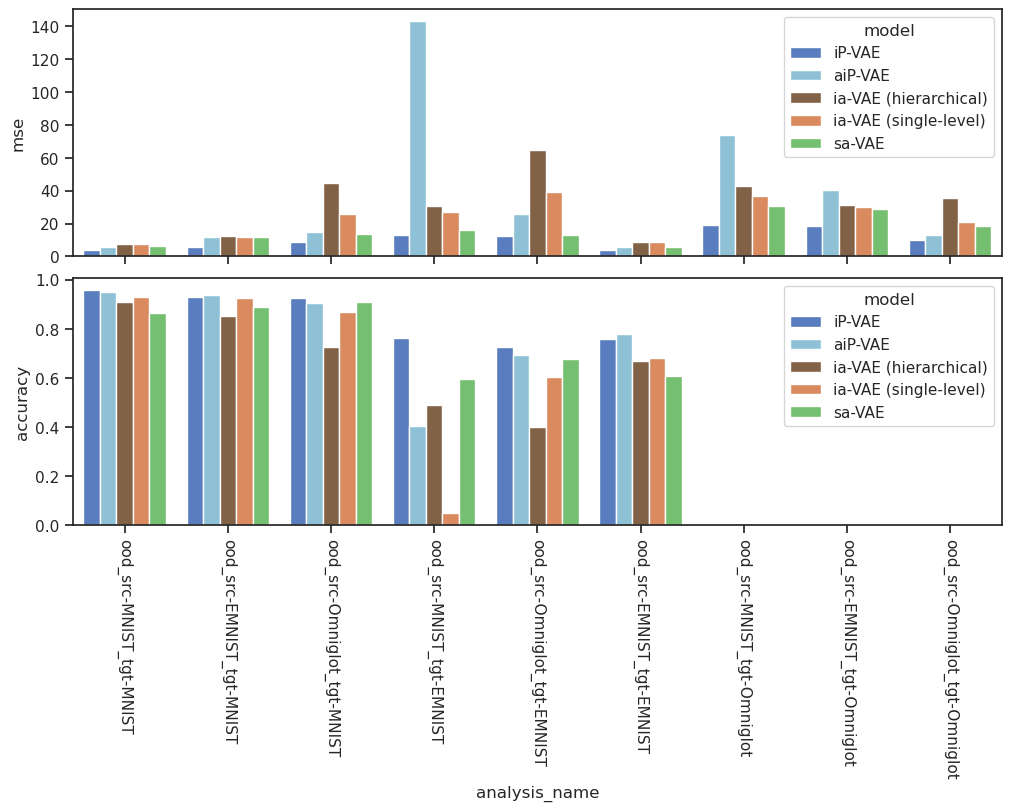

In [18]:
fig, axes = create_figure(2, 1, (10, 8), sharex='col')
for i, y_name in enumerate(['mse', 'accuracy']):
    sns.barplot(
        data=df,
        x='analysis_name',
        order=order2,
        y=y_name,
        hue='model',
        palette=get_palette_models(),
        ax=axes[i],
    )
axes[-1].tick_params(axis='x', rotation=-90)

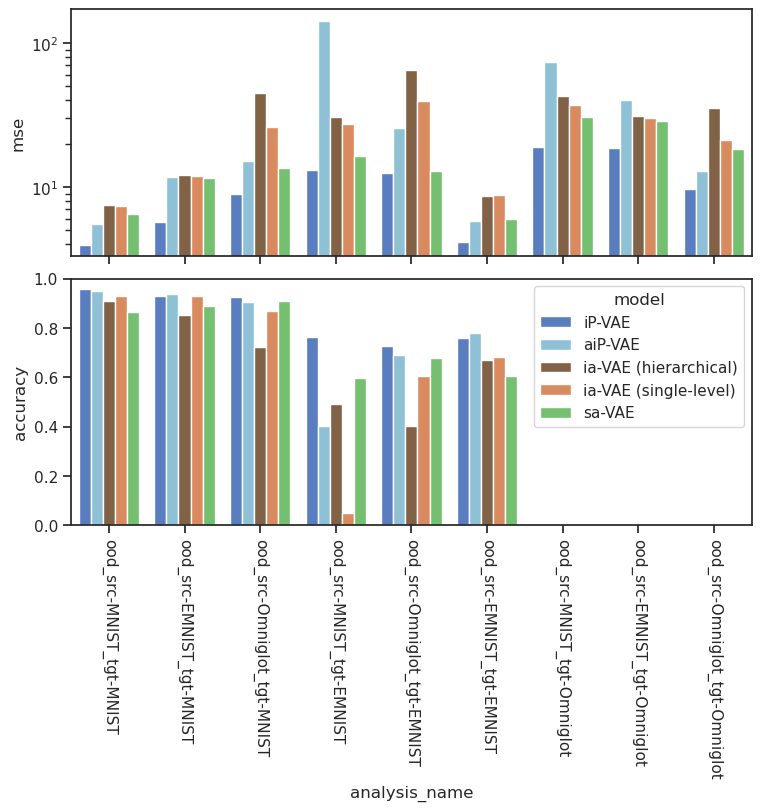

In [19]:
fig, axes = create_figure(2, 1, (7.5, 8), sharex='col')
for i, y_name in enumerate(['mse', 'accuracy']):
    sns.barplot(
        data=df,
        x='analysis_name',
        order=order2,
        y=y_name,
        hue='model',
        palette=get_palette_models(),
        legend=i == 1,
        ax=axes[i],
    )
axes[0].set_yscale('log')
axes[1].set_ylim((0.0, 1.0))
axes[-1].tick_params(axis='x', rotation=-90)

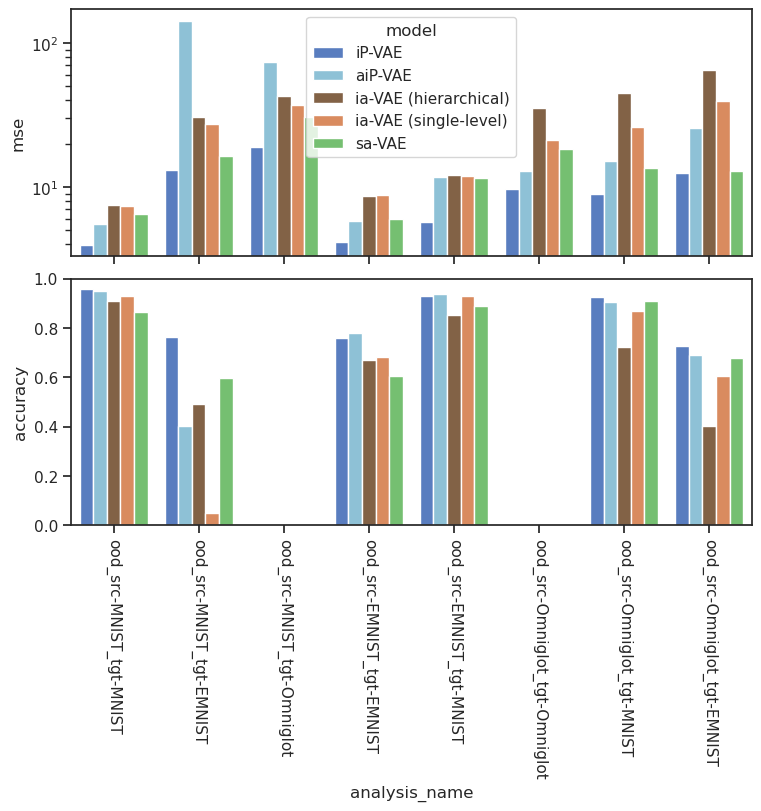

In [20]:
fig, axes = create_figure(2, 1, (7.5, 8), sharex='col')
for i, y_name in enumerate(['mse', 'accuracy']):
    sns.barplot(
        data=df,
        x='analysis_name',
        order=order,
        y=y_name,
        hue='model',
        palette=get_palette_models(),
        legend=i == 0,
        ax=axes[i],
    )
axes[0].set_yscale('log')
axes[1].set_ylim((0.0, 1.0))
axes[-1].tick_params(axis='x', rotation=-90)